### "AuthorToday" short story contest research
the goal of this research is to find out if there is any dependencies between frequency characteristics of fictional story and the viewers respond to it, measured in grades given by contest counsil and likes and views from the audience.

#### Import nessesary libraries

In [2]:
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from pymorphy2 import MorphAnalyzer
%matplotlib inline

#### Load and examine a dataset

In [3]:
dataset = pd.read_json('final_results.json')

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   index            295 non-null    int64 
 1   title            295 non-null    object
 2   href             295 non-null    object
 3   access           295 non-null    object
 4   text_url         295 non-null    object
 5   likes            295 non-null    int64 
 6   views            295 non-null    int64 
 7   comments_number  295 non-null    int64 
 8   comment_urls     295 non-null    object
 9   grades           295 non-null    object
 10  text             295 non-null    object
dtypes: int64(4), object(7)
memory usage: 25.5+ KB


In [5]:
dataset.head()

,index,title,href,access,text_url,likes,views,comments_number,comment_urls,grades,text
0,1,На часах 14:15,https://author.today/work/53594,Свободный,https://author.today/reader/53594,25,885,52,[?page=1&sorting=reverse#comments],"[4, 5, 9, 3, 9, 1, 3, 9, 3, 2, 11]","[На часах 14:15, - Сеть пропала, - цокнула язы..."
1,2,Парящая: Небесный патруль,https://author.today/work/53595,Свободный,https://author.today/reader/53595,20,880,41,[?page=1&sorting=reverse#comments],"[2, 2, 11, 6, 8, 3, 5, 6, 1, 3, 7, 2, 11, 9, 6...","[Парящая: Небесный патруль, Мне всегда было ин..."
2,3,Код Манны,https://author.today/work/53719,Свободный,https://author.today/reader/53719,3,1051,20,[?page=1&sorting=reverse#comments],"[10, 11, 8, 3, 11, 7, 10, 11, 11, 9, 11]","[Код Манны, «Неудачница», «Бездарная», «Уродин..."
3,4,Спасение,https://author.today/work/45769,Свободный,https://author.today/reader/45769,57,3030,49,"[?page=1&sorting=reverse#comments, ?page=2&sor...","[3, 6, 5, 1, 2, 6, 1, 4, 2, 5, 1, 9, 2, 11, 11...","[Спасение, Фантастический рассказ ""Спасение"", ..."
4,5,Маг по особым поручениям,https://author.today/work/53049,Свободный,https://author.today/reader/53049,34,1392,168,"[?page=1&sorting=reverse#comments, ?page=2&sor...","[2, 3, 1, 9, 4, 6, 5, 6, 10, 6]","[Маг по особым поручениям, – Ваши документы, м..."


Dataset contains text scrapped from web and presented as a list of strings, a string for each paragraph of text. There are also list of grades given by contest jury, number of views, likes and comments. Some information like urls, access and text title is probably unnecessary.
#### Drop unnecesary columns and add ones related to text rating by viewers and jury.

In [6]:
dataset.drop(columns = ['href', 'access', 'text_url', 'comment_urls'], inplace = True)

In [7]:
dataset['mean_grade'] = dataset['grades'].apply(lambda x: sum(x) / len(x))
dataset['median_grade'] = dataset['grades'].apply(np.median)
dataset['viewers_liked'] = dataset.apply(lambda row: row['likes'] / row['views'] * 100, axis = 1)

#### Then see how average grades given by jury corresponds with ratio between viewer's likes and views.

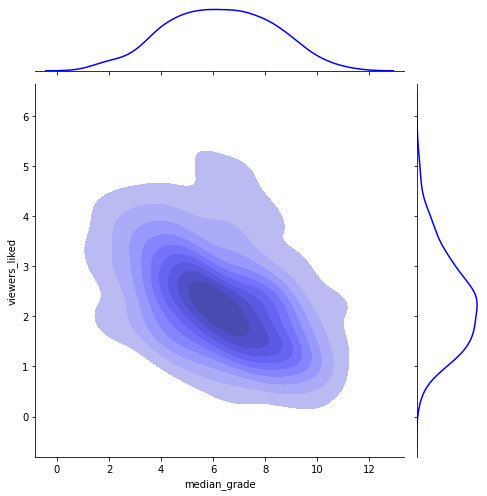

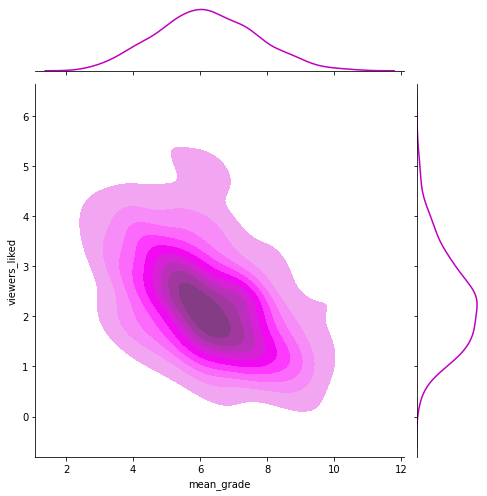

In [8]:
sns.jointplot(x = dataset['median_grade'], y = dataset['viewers_liked'], height = 7, color = 'b', 
              shade = True, kind = 'kde')
sns.jointplot(x = dataset['mean_grade'], y = dataset['viewers_liked'], height = 7, color = 'm', 
              shade = True, kind = 'kde')

Seems like stories with higher grades tend to be liked less by viewers. This may happen because low and high grades causes  too low or too high viewers's expectations respectivly. Then, if story quality doesn't met viewers expectations, they may prefer to like stories with lower rating and do not like higher rated.

To examine the relationship between jury rating and viewer's likes we may check distributions of audience liking ratio for each grade in jury median grades. In this case median grades are used as a categorial data.

In [9]:
pd.unique(dataset['median_grade'])

array([ 4. ,  7. , 10. ,  5. ,  5.5,  8. ,  6. ,  4.5, 11. ,  2. ,  6.5,
        7.5,  3.5,  8.5,  9. ,  3. ,  9.5,  1.5])

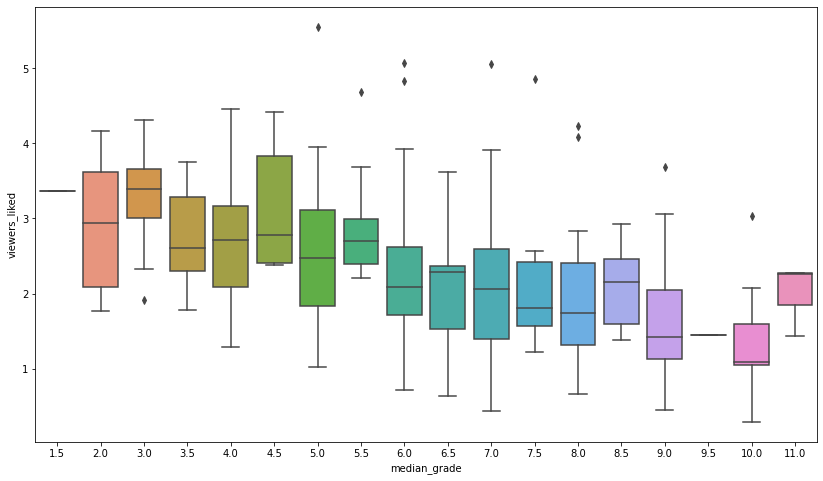

In [10]:
plt.figure(figsize = (14, 8))
sns.boxplot(x = dataset['median_grade'],
           y = dataset['viewers_liked'])

There is also a possibility that stories with higher rating has a bigger average number of views, which causes a lower likes to views ratio. Check this out.

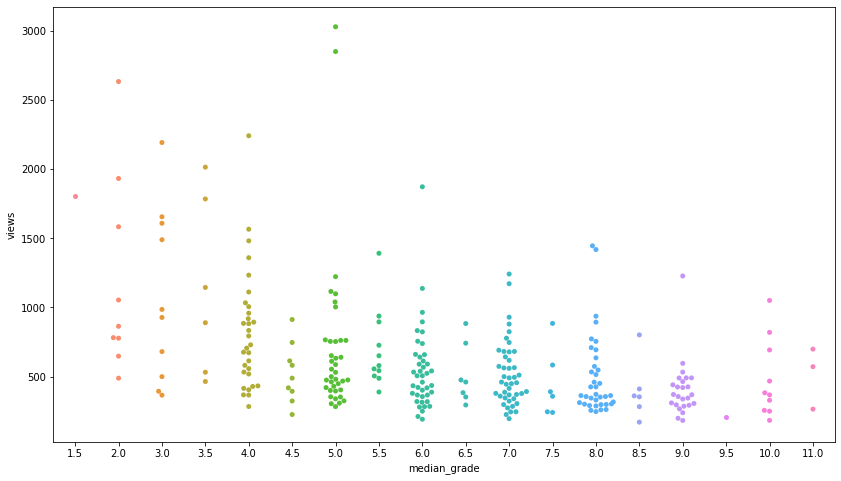

In [16]:
plt.figure(figsize = (14, 8))
#sns.countplot(x = dataset['median_grade'])
sns.swarmplot(x = dataset['median_grade'],
           y = dataset['views'])

As we can see, actual distribution of views is the opposite - range of numbers of views is more wide for low rated stories.

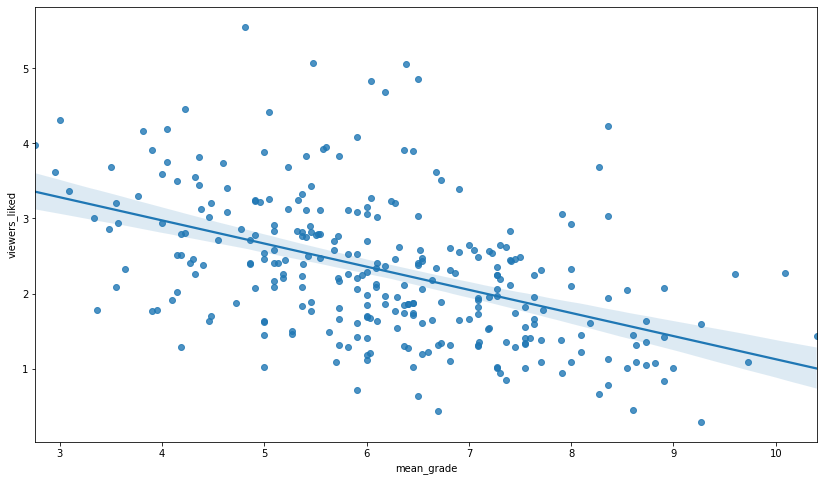

In [18]:
plt.figure(figsize = (14, 8))
sns.regplot(x = dataset['mean_grade'], y = dataset['viewers_liked'])

Linear regression also show that higher mean grade corresponds to lower percent of likes.

#### Check the disributions in jury and viewer's rating.

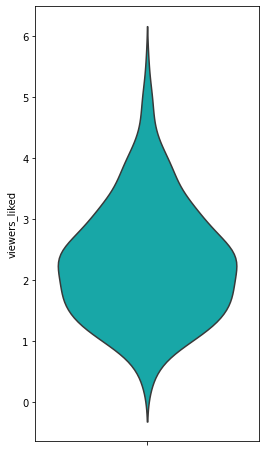

In [13]:
plt.figure(figsize = (4, 8))
sns.violinplot(y = dataset['viewers_liked'], inner = None, color = 'c')

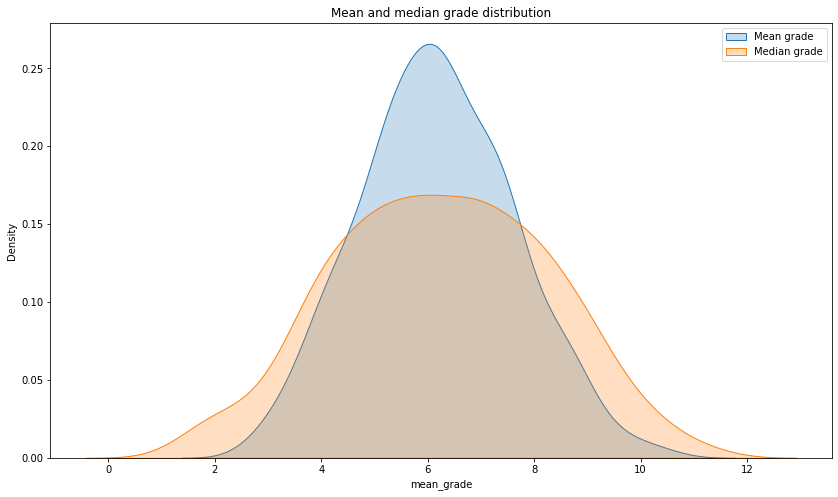

In [25]:
plt.figure(figsize = (14, 8))
sns.kdeplot(data = dataset['mean_grade'], label = 'Mean grade', shade = True)
sns.kdeplot(data = dataset['median_grade'], label = 'Median grade', shade = True)
plt.title('Mean and median grade distribution')
plt.legend()

Viewer's like rating is mostly low, but jury rating distribution is close to normal.
### Adding some functions for text frequency analysys.
First we define functions for:
* splitting text paragraph to sentences
* splitting a sentence to words

Then calculate average word, sentence and paragraph length for each text and examine if any of these charachteristics correlate with text grades.

In [19]:
#Splitting a paragraph to sentences.
def cut2sent(text):
    sentences = re.findall(r'[^.]+[.!?]', text)
    if sentences:
        return sentences
    else:
        return [text]

#Splitting a sentence to words
def cut2words(sent):
    words = re.split(r'[,;:-]\W|\W', sent)
    return [word for word in words if word]

#Find mean and median word length for given text
def word_mean_median(text, metric = 'mean'):
    if isinstance(text, list):
        sentences = cut2sent(' '.join(text))
    else:
        sentences = cut2sent(text)
    lengths = []
    for sent in sentences:
        lengths.extend([len(word) for word in cut2words(sent)])
    if metric == 'median':
        return np.median(lengths)
    else:
        return np.mean(lengths)

#Find mean or median sentence lendth (measured in number of words) for given text
def sentence_mean_median(text, metric = 'mean'):
    if isinstance(text, list):
        sentences = cut2sent(' '.join(text))
    else:
        sentences = cut2sent(text)
    lengths = []
    for sent in sentences:
        lengths.append(len(cut2words(sent)))
    if metric == 'median':
        return np.median(lengths)
    else:
        return np.mean(lengths)

#Mean or median paragraph length (measured in number of words)
def paragraph_mean_median(pars, metric = 'mean'):
    lengths = []
    for par in pars:
        length_words = 0
        for sentence in cut2sent(par):
            length_words += len(cut2words(sentence))
        lengths.append(length_words)
    if metric == 'median':
        return np.median(lengths)
    else:
        return np.mean(lengths)

Creating new dataset with these basic frequency characteristics.

In [22]:
freq_set = dataset[['mean_grade', 'median_grade', 'viewers_liked', 'text']].copy()
freq_set['mean_word_length'] = freq_set['text'].apply(word_mean_median)
freq_set['median_word_length'] = freq_set['text'].apply(lambda x: word_mean_median(x, 'median'))
freq_set['mean_sentence_length'] = freq_set['text'].apply(sentence_mean_median)
freq_set['median_sentence_length'] = freq_set['text'].apply(lambda x: sentence_mean_median(x, 'median'))
freq_set['mean_paragraph_length'] = freq_set['text'].apply(paragraph_mean_median)
freq_set['median_paragraph_length'] = freq_set['text'].apply(lambda x: paragraph_mean_median(x, 'median'))

In [23]:
freq_set.head()

,mean_grade,median_grade,viewers_liked,text,mean_word_length,median_word_length,mean_sentence_length,median_sentence_length,mean_paragraph_length,median_paragraph_length
0,5.363636,4.0,2.824859,"[На часах 14:15, - Сеть пропала, - цокнула язы...",5.576987,6.0,7.268687,7.0,13.976562,11.0
1,6.863636,7.0,2.272727,"[Парящая: Небесный патруль, Мне всегда было ин...",5.442478,5.0,12.421986,11.0,29.637931,12.0
2,9.272727,10.0,0.285442,"[Код Манны, «Неудачница», «Бездарная», «Уродин...",4.968131,5.0,8.903581,8.0,60.364486,60.0
3,5.454545,5.0,1.881188,"[Спасение, Фантастический рассказ ""Спасение"", ...",5.050151,5.0,8.803191,8.0,22.326389,10.5
4,5.200000,5.5,2.442529,"[Маг по особым поручениям, – Ваши документы, м...",5.503785,5.0,11.060465,10.0,20.539823,10.0


In [31]:
freq_set[['mean_word_length', 'mean_sentence_length', 'mean_paragraph_length']].describe()

,mean_word_length,mean_sentence_length,mean_paragraph_length
count,295.000000,295.000000,295.000000
mean,5.366944,11.576963,27.036181
std,0.269880,2.397597,11.945487
min,4.692995,5.850746,6.865625
25%,5.191784,9.960337,19.666321
50%,5.348303,11.326667,24.578947
75%,5.540899,12.764065,31.543889
max,6.339759,22.526515,116.893617


Distribution of basic frequency characteristics:


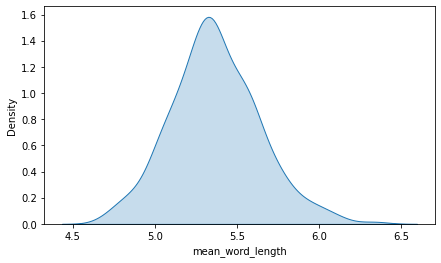

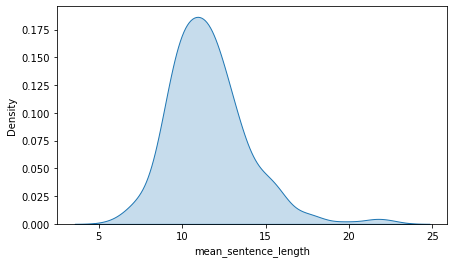

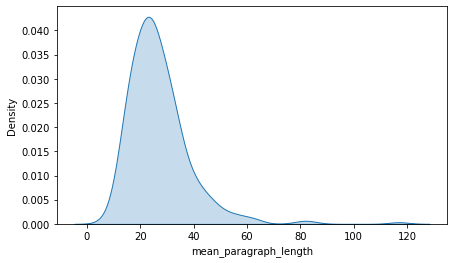

In [32]:
print('Distribution of basic frequency characteristics:')
for key in ['mean_word_length', 'mean_sentence_length', 'mean_paragraph_length']:
    plt.figure(figsize = (7, 4))
    sns.kdeplot(data = freq_set[key], label = key, shade = True)
    plt.show()

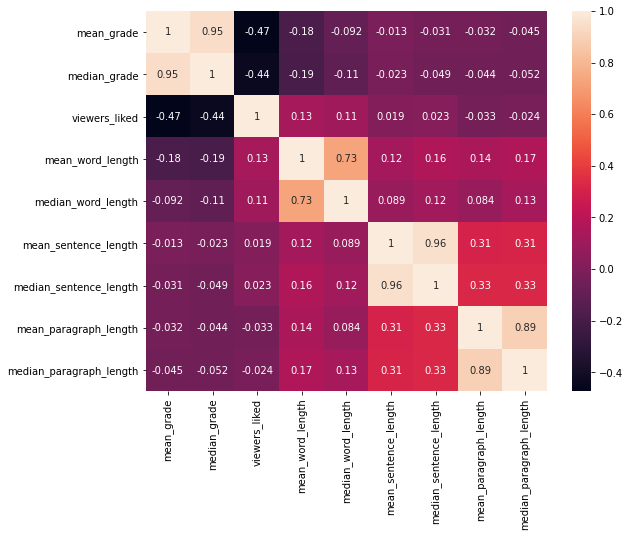

In [18]:
plt.figure(figsize = (9, 7))
sns.heatmap(freq_set.corr(), annot = True)

Since there is no significant correlation between grades and text frequency charachteristics, we may try to make a model for predicting mean jury rating and viewer's like rating for text by it's frequency characteristics.

In [19]:
features = ['mean_word_length', 'mean_sentence_length', 'mean_paragraph_length']
X = freq_set[features]
y = freq_set['viewers_liked']

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

freq_liking_model = RandomForestRegressor(random_state = 1)
freq_liking_model.fit(train_X, train_y)
like_preds = freq_liking_model.predict(val_X)
print(freq_set['viewers_liked'].describe())
MAE = mean_absolute_error(val_y, like_preds)
print(MAE)
print(freq_set[freq_set['viewers_liked'] < MAE].count())

count    295.000000
mean       2.303484
std        0.938132
min        0.285442
25%        1.627492
50%        2.247191
75%        2.833435
max        5.555556
Name: viewers_liked, dtype: float64
0.7717058169018383
mean_grade                 6
median_grade               6
viewers_liked              6
text                       6
mean_word_length           6
median_word_length         6
mean_sentence_length       6
median_sentence_length     6
mean_paragraph_length      6
median_paragraph_length    6
dtype: int64


In [20]:
features = ['mean_word_length', 'mean_sentence_length', 'mean_paragraph_length']
X = freq_set[features]
y = freq_set['mean_grade']

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

freq_rating_model = RandomForestRegressor(random_state = 1)
freq_rating_model.fit(train_X, train_y)
like_preds = freq_rating_model.predict(val_X)
print(freq_set['mean_grade'].describe())
MAE = mean_absolute_error(val_y, like_preds)
print(MAE)

count    295.000000
mean       6.175433
std        1.441815
min        2.761905
25%        5.181818
50%        6.090909
75%        7.213636
max       10.400000
Name: mean_grade, dtype: float64
1.1943643566456066


As we can see, predictions based on basic frequency characteristics are not very accurate.
So we will try to use characteristics based on frequency of parts of speech.

In [33]:
morph = MorphAnalyzer()

#Basic function for extraction pymorphy2 OpencorporaTag for given word
def word_data(word):
    all_data = morph.parse(word)
    selected_tag = sorted(all_data, key = lambda data: data.score, reverse = True)[0]
    return selected_tag

#Function for ranking word according to its semantic value
def word_rank(word):
    word_rank = 6
    ranks = [{'rank': 1, 'forms': {'NOUN': 'nomn', 'NPRO': 'nomn', 'VERB': '', 'INFN': ''}},
            {'rank': 2, 'forms': {'NOUN': '', 'NPRO': '', 'PRTF': '', 'PRTS': '', 'GRND': ''}},
            {'rank': 3, 'forms': {'ADJF': '', 'ADJS': '', 'ADVB': '', 'PRED': ''}},
            {'rank': 4, 'forms': {'COMP': '', 'NUMR': ''}},
            {'rank': 5, 'forms': {'PREP': '', 'CONJ': '', 'PRCL': ''}},
            {'rank': 6, 'forms': {'INTJ': ''}}]
    description = word_data(word)
    for rank in ranks:
        for key in rank['forms']:
            if key in description.tag and rank['forms'][key] and rank['forms'][key] in description.tag:
                word_rank = rank['rank']
                break
            elif key in description.tag and not rank['forms'][key]:
                word_rank = rank['rank']
                break
    return word_rank

#Function for calculating stop-words ratio in given words
def non_semantic_ratio(words):
    non_semantic = 0
    for word in words:
        if word_rank(word) >= 4:
            non_semantic += 1 
    return non_semantic / len(words)

#Function for calculating ipm for every POS in given words
def count_POS(words):
    keys = ['ADJF', 'ADJS', 'ADVB', 'COMP', 'CONJ', 'GRND', 'INFN', 'INTJ', 'NOUN', 'NPRO', 
            'NUMR', 'PRCL', 'PRED', 'PREP', 'PRTF', 'PRTS', 'VERB']
    POS_count = dict.fromkeys(keys, 0)
    for word in words:
        oc_tag = word_data(word)
        key = oc_tag.tag.POS
        if key in keys:
            POS_count[key] += 1
    total = len(words)
    for key in POS_count:
        POS_count[key] = round((POS_count[key] / total) * 1000000, 3)
    return list(POS_count.values())

#Function for turning text to list of words
def text2words(text):
    if isinstance(text, list):
        sentences = cut2sent(' '.join(text))
    else:
        sentences = cut2sent(text)
    words = []
    for sentence in sentences:
        words.extend(cut2words(sentence))
    return words

Processing texts with pymorphy2 takes plenty of time, so we saved this data in purpose to not calculate it again.

In [34]:
#linguo_data = dataset[['mean_grade', 'median_grade', 'viewers_liked', 'text']].copy()
#linguo_data['stop_words_ratio'] = linguo_data['text'].apply(lambda x: non_semantic_ratio(text2words(x)))
#linguo_data['POS_vector'] = linguo_data['text'].apply(lambda x: count_POS(text2words(x)))
#linguo_data.to_json('linguo_data.json')

linguo_data = pd.read_json('linguo_data.json')

In [35]:
linguo_data.head()

,mean_grade,median_grade,viewers_liked,text,stop_words_ratio,POS_vector
0,5.363636,4.0,2.824859,"[На часах 14:15, - Сеть пропала, - цокнула язы...",0.228182,"[98110.061, 10839.355, 45858.81, 2223.457, 675..."
1,6.863636,7.0,2.272727,"[Парящая: Небесный патруль, Мне всегда было ин...",0.254068,"[116471.596, 7422.21, 63659.72, 3996.574, 8621..."
2,9.272727,10.0,0.285442,"[Код Манны, «Неудачница», «Бездарная», «Уродин...",0.276145,"[102568.069, 9591.584, 54146.04, 5414.604, 108..."
3,5.454545,5.0,1.881188,"[Спасение, Фантастический рассказ ""Спасение"", ...",0.264048,"[96072.508, 10574.018, 71299.094, 5135.952, 10..."
4,5.200000,5.5,2.442529,"[Маг по особым поручениям, – Ваши документы, м...",0.243482,"[126997.477, 5466.779, 57611.438, 5046.257, 92..."


Visualisation of vector is more complicated, so we will compare POS vector for each text with average vector and use their similarity for visualisation.

In [36]:
def cosine_similarity(a, b):
    return np.dot(a, b)/np.sqrt(a.dot(a)*b.dot(b))

#For further processing we should turn POS_vectors represented as lists to numpy arrays.

linguo_data['np_vector'] = linguo_data['POS_vector'].apply(lambda x: np.array(x))
mean_vector = np.mean(linguo_data['np_vector'])

In [37]:
linguo_data['np_vector'][3]

array([ 96072.508,  10574.018,  71299.094,   5135.952, 103927.492,
         7552.87 ,  34138.973,   3927.492, 222658.61 , 123564.955,
         3021.148,  55891.239,   9063.444,  90634.441,   5438.066,
         1812.689, 153776.435])

In [38]:
linguo_data['cosine_similarity'] = linguo_data['np_vector'].apply(lambda x: cosine_similarity(mean_vector, x))

Check for correlations:

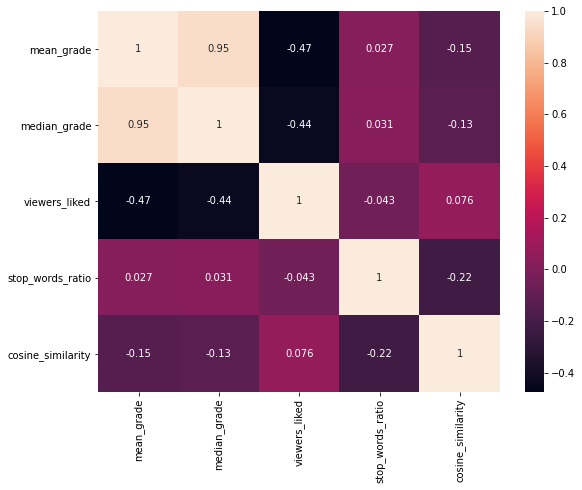

In [39]:
plt.figure(figsize = (9, 7))
sns.heatmap(linguo_data.corr(), annot = True)

In [28]:
#linguo_data.drop(columns = ['subtracted_vector', 'subtracted_cs'], inplace = True)
linguo_data.head()

,mean_grade,median_grade,viewers_liked,text,stop_words_ratio,POS_vector,np_vector,cosine_similarity
0,5.363636,4.0,2.824859,"[На часах 14:15, - Сеть пропала, - цокнула язы...",0.228182,"[98110.061, 10839.355, 45858.81, 2223.457, 675...","[98110.061, 10839.355, 45858.81, 2223.457, 675...",0.988661
1,6.863636,7.0,2.272727,"[Парящая: Небесный патруль, Мне всегда было ин...",0.254068,"[116471.596, 7422.21, 63659.72, 3996.574, 8621...","[116471.596, 7422.21, 63659.72, 3996.574, 8621...",0.996621
2,9.272727,10.0,0.285442,"[Код Манны, «Неудачница», «Бездарная», «Уродин...",0.276145,"[102568.069, 9591.584, 54146.04, 5414.604, 108...","[102568.069, 9591.584, 54146.04, 5414.604, 108...",0.985222
3,5.454545,5.0,1.881188,"[Спасение, Фантастический рассказ ""Спасение"", ...",0.264048,"[96072.508, 10574.018, 71299.094, 5135.952, 10...","[96072.508, 10574.018, 71299.094, 5135.952, 10...",0.973358
4,5.200000,5.5,2.442529,"[Маг по особым поручениям, – Ваши документы, м...",0.243482,"[126997.477, 5466.779, 57611.438, 5046.257, 92...","[126997.477, 5466.779, 57611.438, 5046.257, 92...",0.992491


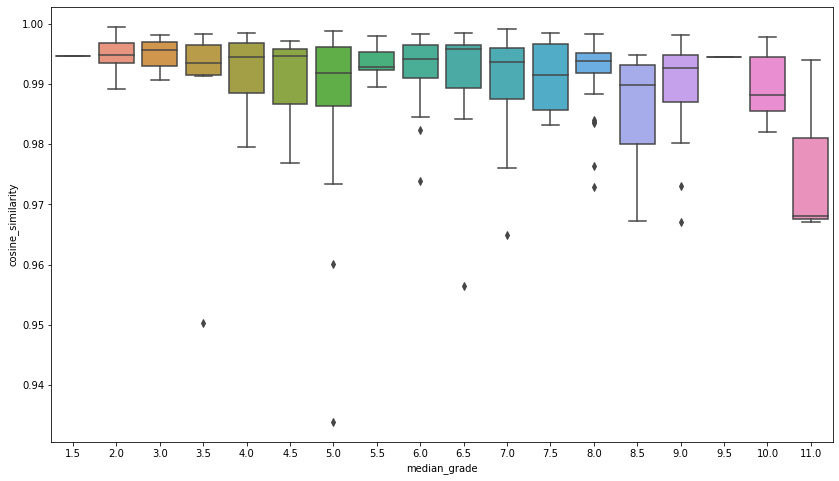

In [29]:
plt.figure(figsize = (14, 8))
sns.boxplot(x = linguo_data['median_grade'], y = linguo_data['cosine_similarity'])

In [35]:
#Trying to make a model with this dataset
features = ['stop_words_ratio', 'cosine_similarity']
X = linguo_data[features]
y = linguo_data['viewers_liked']

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

linguo_model = RandomForestRegressor(random_state = 1)
linguo_model.fit(train_X, train_y)
like_preds = linguo_model.predict(val_X)
print(linguo_data['viewers_liked'].describe())
MAE = mean_absolute_error(val_y, like_preds)
print('\n', MAE)

count    295.000000
mean       2.303484
std        0.938132
min        0.285442
25%        1.627492
50%        2.247191
75%        2.833435
max        5.555556
Name: viewers_liked, dtype: float64

 0.8023383179449052


In [34]:
#For a jury rating
features = ['stop_words_ratio', 'cosine_similarity']
X = linguo_data[features]
y = linguo_data['mean_grade']

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

linguo_model = RandomForestRegressor(random_state = 1)
linguo_model.fit(train_X, train_y)
rating_preds = linguo_model.predict(val_X)
print(linguo_data['mean_grade'].describe())
MAE = mean_absolute_error(val_y, rating_preds)
print('\n', MAE)

count    295.000000
mean       6.175433
std        1.441815
min        2.761905
25%        5.181818
50%        6.090909
75%        7.213636
max       10.400000
Name: mean_grade, dtype: float64

 1.4073466567187565


In [40]:
#Let's try to make predictions based on POS vector of the text only
keys = ['ADJF', 'ADJS', 'ADVB', 'COMP', 'CONJ', 'GRND', 'INFN', 'INTJ', 'NOUN', 'NPRO', 
            'NUMR', 'PRCL', 'PRED', 'PREP', 'PRTF', 'PRTS', 'VERB']
POS_set = linguo_data[['mean_grade', 'viewers_liked', 'POS_vector']].copy()
for key in keys:
    POS_set[key] = POS_set['POS_vector'].apply(lambda x: x[keys.index(key)])
#POS_set.head()

X = POS_set[keys]
y = POS_set['viewers_liked']

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

POS_model = RandomForestRegressor(random_state = 1)
POS_model.fit(train_X, train_y)
like_preds = POS_model.predict(val_X)
print(POS_set['viewers_liked'].describe())
MAE = mean_absolute_error(val_y, like_preds)
print('\n', MAE)

count    295.000000
mean       2.303484
std        0.938132
min        0.285442
25%        1.627492
50%        2.247191
75%        2.833435
max        5.555556
Name: viewers_liked, dtype: float64

 0.613168952918892


In [71]:
#Function for calculating mean POS vector for sentences of given text
def sentence_vectors(text):
    keys = ['ADJF', 'ADJS', 'ADVB', 'COMP', 'CONJ', 'GRND', 'INFN', 'INTJ', 'NOUN', 'NPRO', 
            'NUMR', 'PRCL', 'PRED', 'PREP', 'PRTF', 'PRTS', 'VERB']
    vectors = []
    if isinstance(text, list):
        sentences = cut2sent(' '.join(text))
    else:
        sentences = cut2sent(text)
    for sentence in sentences:
        POS_presence = dict.fromkeys(keys, 0)
        for word in cut2words(sentence):
            oc_tag = word_data(word)
            key = oc_tag.tag.POS
            if key in keys:
                POS_presence[key] = 1
        values = list(POS_presence.values())
        vectors.append(np.array(values))
    return vectors    

In [84]:
linguo_data['mean_sentence_vector'] = 0

In [91]:
linguo_data['mean_sentence_vector'] = linguo_data['text'].apply(lambda x: np.mean(sentence_vectors(x), axis = 0))

In [92]:
mean_v = np.mean(linguo_data['mean_sentence_vector'], axis = 0)
mean_v

array([0.60740869, 0.09654741, 0.4903931 , 0.0513701 , 0.59147031,
       0.15861961, 0.24923872, 0.02236441, 0.90204999, 0.50369825,
       0.05232393, 0.36315387, 0.04500802, 0.65102308, 0.13070122,
       0.02644038, 0.87246077])

In [93]:
linguo_data['sentence_cos_sim'] = linguo_data['mean_sentence_vector'].apply(lambda x: cosine_similarity(x, mean_v))

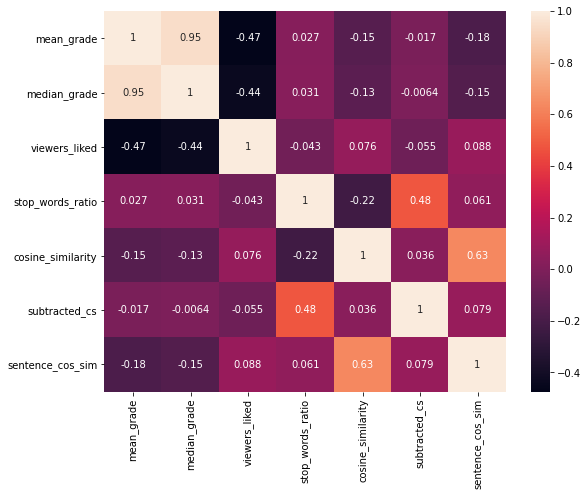

In [94]:
plt.figure(figsize = (9, 7))
sns.heatmap(linguo_data.corr(), annot = True)

In [98]:
linguo_data.to_json('sentence_vectors.json')